## Imports & All of Texas Data

In [2]:
### SECTION 0: Imports + data

import geopandas as gpd
import networkx as nx
import pickle
import matplotlib.pyplot as plt
from shapely.geometry import box, Point, LineString
import pandas as pd
import numpy as np
import random


# 0.1 Load road shapefile
roads = gpd.read_file("gis_osm_roads_free_1.shp")

major_classes = [
    "motorway", "trunk", "primary", "secondary", "tertiary",
    "motorway_link", "trunk_link", "primary_link",
    "secondary_link", "tertiary_link",
    "residential", "unclassified", "living_street"
]

roads_major = roads[roads["fclass"].isin(major_classes)]
print(len(roads_major), "major road segments in Texas")

# 0.2 Load statewide time-weighted directed graph (already EPSG:3857)
with open("texas_roads.pkl", "rb") as f:
    G = pickle.load(f)

print("Statewide graph:", G.number_of_nodes(), "nodes,", G.number_of_edges(), "edges")


1275397 major road segments in Texas
Statewide graph: 5828743 nodes, 7024931 edges


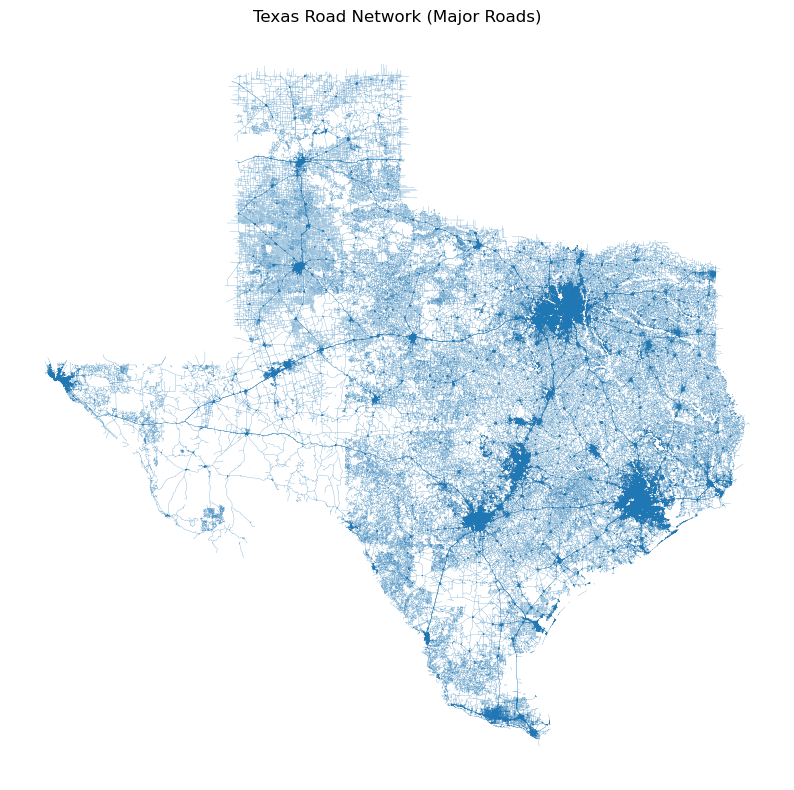

In [3]:
#Entire Texas:
# Use the same 'roads_major' from earlier
roads_tx_proj = roads_major.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 10))
roads_tx_proj.plot(ax=ax, linewidth=0.15)
ax.set_title("Texas Road Network (Major Roads)")
ax.set_axis_off()
plt.show()

## Leander & Cedar Park - Question 1 Analysis

14505 road segments in Leander + Cedar Park


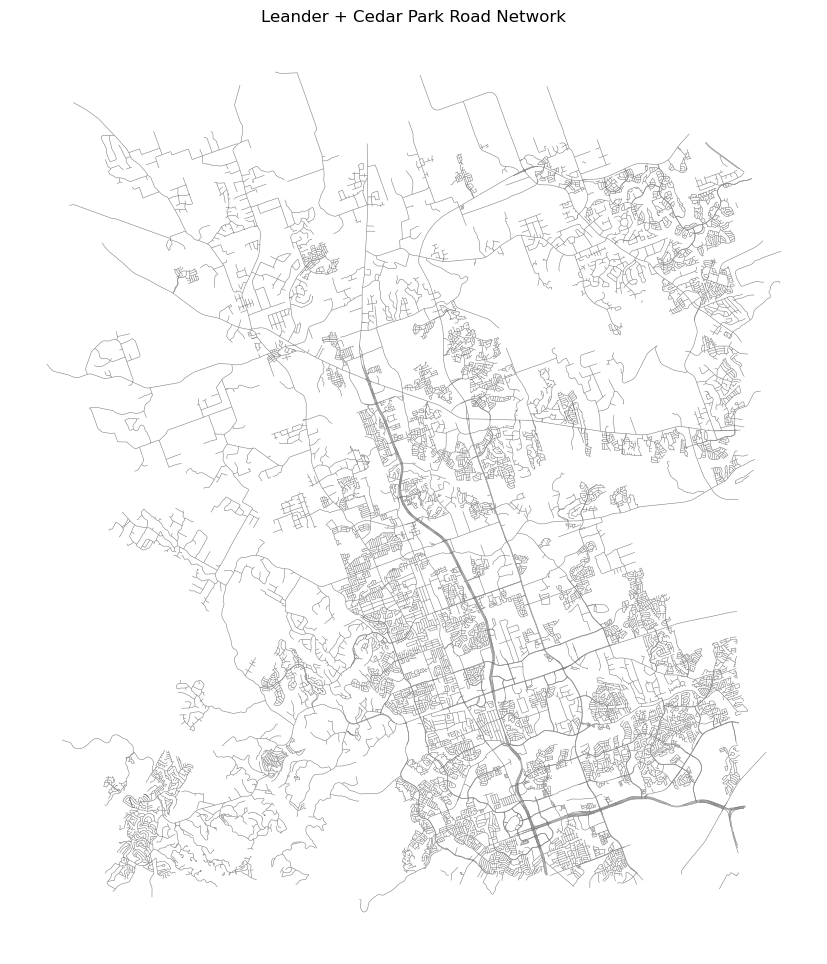

Leander + Cedar Park bbox in EPSG:3857: -10912670.410153793 -10873493.507987987 3559471.498539673 3604291.6463674316
Leander + Cedar Park node count: 123453
Largest CC (CP+Lea): 8941 nodes, 14802 edges
Merged CP+Lea graph: 8499 nodes, 14105 edges


In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import networkx as nx
import pandas as pd
import random

# --- 0.1 Leander + Cedar Park bounding box in WGS84 ---
cedar_lea_bbox = (-98.00, -97.70, 30.45, 30.75)  # (minx, maxx, miny, maxy) in lon/lat

# Filter *roads* by bbox (WGS84)
cp_lea_roads = roads_major.cx[
    cedar_lea_bbox[0]:cedar_lea_bbox[1],
    cedar_lea_bbox[2]:cedar_lea_bbox[3]
]

print(len(cp_lea_roads), "road segments in Leander + Cedar Park")

# Project to 3857 for plotting & bounds
cp_lea_proj = cp_lea_roads.to_crs(epsg=3857)

# Quick map
fig, ax = plt.subplots(figsize=(12, 12))
cp_lea_proj.plot(ax=ax, linewidth=0.4, color="gray")
ax.set_title("Leander + Cedar Park Road Network")
ax.set_axis_off()
plt.show()

# --- 0.2 Subset the statewide graph G using the same projected bounds ---

x_min, y_min, x_max, y_max = cp_lea_proj.total_bounds
print("Leander + Cedar Park bbox in EPSG:3857:", x_min, x_max, y_min, y_max)

cp_lea_nodes = [
    n for n in G.nodes
    if x_min <= n[0] <= x_max and y_min <= n[1] <= y_max
]

print("Leander + Cedar Park node count:", len(cp_lea_nodes))

G_cp_lea = G.subgraph(cp_lea_nodes).copy()
#print("Raw CP+Lea subgraph:", G_cp_lea.number_of_nodes(), "nodes,", G_cp_lea.number_of_edges(), "edges")

# --- 0.3 Keep largest weakly connected component ---
components = list(nx.weakly_connected_components(G_cp_lea))
largest = max(components, key=len)
G_cp_lea_cc = G_cp_lea.subgraph(largest).copy()

print("Largest CC (CP+Lea):", G_cp_lea_cc.number_of_nodes(), "nodes,", G_cp_lea_cc.number_of_edges(), "edges")

# --- 0.4 Snap/merge nearby nodes (e.g., 15 m) to clean intersections ---

snap = 15.0  # meters

nodes_df = pd.DataFrame(list(G_cp_lea_cc.nodes()), columns=["x", "y"])
nodes_df["x_snap"] = (nodes_df["x"] / snap).round() * snap
nodes_df["y_snap"] = (nodes_df["y"] / snap).round() * snap

mapping = {
    (row.x, row.y): (row.x_snap, row.y_snap)
    for row in nodes_df.itertuples(index=False)
}

G_cp_lea_merged = nx.DiGraph()

for u, v, data in G_cp_lea_cc.edges(data=True):
    u2 = mapping[u]
    v2 = mapping[v]
    if u2 == v2:
        continue

    if G_cp_lea_merged.has_edge(u2, v2):
        existing_tt = G_cp_lea_merged[u2][v2].get("travel_time_s", float("inf"))
        new_tt = data.get("travel_time_s", existing_tt)
        if new_tt < existing_tt:
            G_cp_lea_merged[u2][v2].update(data)
    else:
        G_cp_lea_merged.add_edge(u2, v2, **data)

print("Merged CP+Lea graph:", G_cp_lea_merged.number_of_nodes(), "nodes,",
      G_cp_lea_merged.number_of_edges(), "edges")

# Roads in 3857 for joins (we’ll reuse this a lot)
roads_3857 = cp_lea_roads.to_crs(epsg=3857)


- Line 1: The bounding box coordinates for Leander and Cedar Park
- Line 2 (123453 Nodes): total number of nodes returned inside your bounding box. Includes irrelevant nodes from waterways, footpaths, dead ends, driveway points, parking lots, etc. 
- Line 3 (8941 Nodes): Filtered out irrelevant networks. The largest connected road network contained 8941 Nodes and 14802 edges. 
- Line 4 (8499 Nodes): Employ edge merging where long roads with many mid-block shape nodes get turned into single edges and parallel overlapping geometries get merged.

14505 road segments in Leander + Cedar Park


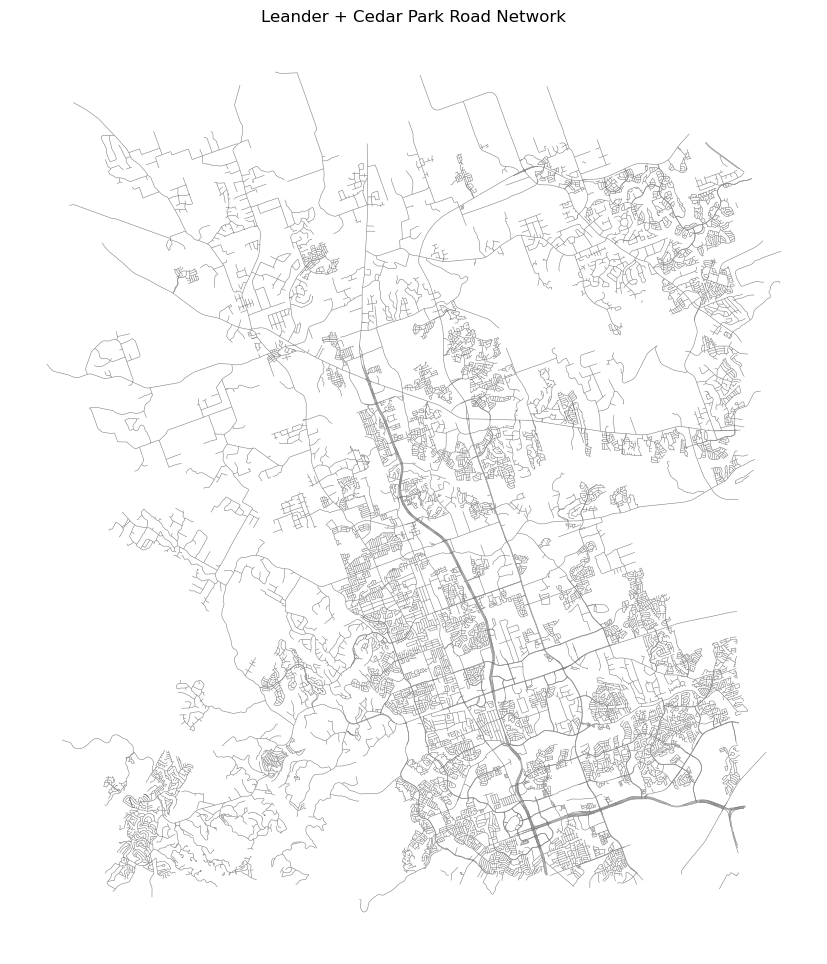

CP+Lea bbox in EPSG:3857: -10912670.410153793 -10873493.507987987 3559471.498539673 3604291.6463674316
Leander + Cedar Park node count: 123453
Raw CP+Lea subgraph: 123453 nodes, 153055 edges
Largest Connected Components (CP+Leander): 8941 nodes, 14802 edges
Merged CP+Lea graph: 8499 nodes, 14105 edges


In [7]:
#Build Leander + Cedar Park graph (no polygons)

# Leander + Cedar Park bounding box in WGS84
cedar_lea_bbox = (-98.00, -97.70, 30.45, 30.75)  # (minx, maxx, miny, maxy)

# Filter roads by bbox (still WGS84)
cp_lea_roads = roads_major.cx[
    cedar_lea_bbox[0]:cedar_lea_bbox[1],
    cedar_lea_bbox[2]:cedar_lea_bbox[3]
]

print(len(cp_lea_roads), "road segments in Leander + Cedar Park")

# Project to 3857 for plotting & bounds
cp_lea_proj = cp_lea_roads.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(12, 12))
cp_lea_proj.plot(ax=ax, linewidth=0.4, color="gray")
ax.set_title("Leander + Cedar Park Road Network")
ax.set_axis_off()
plt.show()

# 1.2 Subset statewide graph G using same projected bounds
x_min, y_min, x_max, y_max = cp_lea_proj.total_bounds
print("CP+Lea bbox in EPSG:3857:", x_min, x_max, y_min, y_max)

cp_lea_nodes = [
    n for n in G.nodes
    if x_min <= n[0] <= x_max and y_min <= n[1] <= y_max
]

print("Leander + Cedar Park node count:", len(cp_lea_nodes))

G_cp_lea = G.subgraph(cp_lea_nodes).copy()
print("Raw CP+Lea subgraph:", G_cp_lea.number_of_nodes(), "nodes,",
      G_cp_lea.number_of_edges(), "edges")

# 1.3 Keep largest weakly connected component
components = list(nx.weakly_connected_components(G_cp_lea))
largest = max(components, key=len)
G_cp_lea_cc = G_cp_lea.subgraph(largest).copy()

print("Largest Connected Components (CP+Leander):", G_cp_lea_cc.number_of_nodes(), "nodes,",
      G_cp_lea_cc.number_of_edges(), "edges")

# 1.4 Snap/merge nearby nodes (clean intersections)
snap = 15.0  # meters

nodes_df = pd.DataFrame(list(G_cp_lea_cc.nodes()), columns=["x", "y"])
nodes_df["x_snap"] = (nodes_df["x"] / snap).round() * snap
nodes_df["y_snap"] = (nodes_df["y"] / snap).round() * snap

mapping = {
    (row.x, row.y): (row.x_snap, row.y_snap)
    for row in nodes_df.itertuples(index=False)
}

G_cp_lea_merged = nx.DiGraph()

for u, v, data in G_cp_lea_cc.edges(data=True):
    u2 = mapping[u]
    v2 = mapping[v]
    if u2 == v2:
        continue

    if G_cp_lea_merged.has_edge(u2, v2):
        existing_tt = G_cp_lea_merged[u2][v2].get("travel_time_s", float("inf"))
        new_tt = data.get("travel_time_s", existing_tt)
        if new_tt < existing_tt:
            G_cp_lea_merged[u2][v2].update(data)
    else:
        G_cp_lea_merged.add_edge(u2, v2, **data)

print("Merged CP+Lea graph:", G_cp_lea_merged.number_of_nodes(), "nodes,",
      G_cp_lea_merged.number_of_edges(), "edges")

# Roads in EPSG:3857 limited to this area (used later for joins)
roads_3857 = cp_lea_roads.to_crs(epsg=3857)


14505 road segments in Leander + Cedar Park


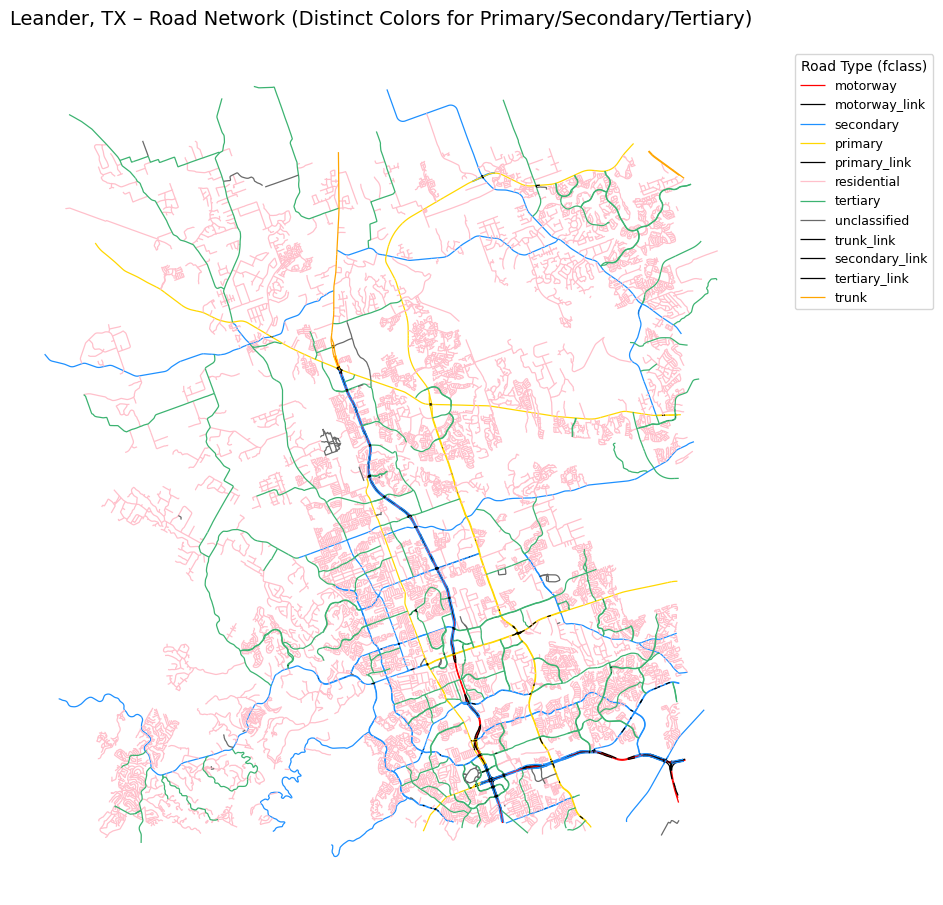

In [8]:
# --- Leander + Cedar Park bounding box ---
cedar_lea_bbox = (-98.00, -97.70, 30.45, 30.75)

# Filter roads by bbox (still in WGS84 here)
cp_lea_roads = roads_major.cx[
    cedar_lea_bbox[0]:cedar_lea_bbox[1],
    cedar_lea_bbox[2]:cedar_lea_bbox[3]
]

print(len(cp_lea_roads), "road segments in Leander + Cedar Park")

# Project to 3857 for plotting
cp_lea_proj = cp_lea_roads.to_crs(epsg=3857)

# CUSTOM color palette
color_map = {
    "motorway": "red",
    "trunk": "orange",
    "primary": "gold",
    "secondary": "dodgerblue",
    "tertiary": "mediumseagreen",
    
    # Minor roads
    "residential": "pink",
    "unclassified": "dimgray",
    "living_street": "lightgray",
    "service": "lightgray",
    
    # Tracks
    "track": "saddlebrown",
    "track_grade1": "saddlebrown",
    "track_grade2": "sienna",
    "track_grade3": "peru",
    "track_grade4": "tan",
    "track_grade5": "wheat",

    # Walking/bike
    "cycleway": "purple",
    "footway": "forestgreen",
    "path": "darkgreen",
    "bridleway": "darkcyan",
}

# fallback color if type not in dict
default_color = "black"

# Determine unique road classes
road_types = cp_lea_proj["fclass"].unique()

# Plot
fig, ax = plt.subplots(figsize=(11, 11))

for rtype in road_types:
    subset = cp_lea_proj[cp_lea_proj["fclass"] == rtype]
    clr = color_map.get(rtype, default_color)
    subset.plot(ax=ax, color=clr, linewidth=0.9, label=rtype)

ax.set_title("Leander, TX – Road Network (Distinct Colors for Primary/Secondary/Tertiary)", fontsize=14)
ax.set_axis_off()

# Legend outside the map
ax.legend(
    title="Road Type (fclass)",
    loc="upper left",
    bbox_to_anchor=(1.05, 1),
    fontsize=9
)

plt.show()


In [9]:
### SECTION 2 (Q1): Central hubs in CP+Lea

print("Computing degree centrality...")
deg = nx.degree_centrality(G_cp_lea_merged)

print("Computing closeness centrality (travel time)...")
clo = nx.closeness_centrality(
    G_cp_lea_merged,
    distance="travel_time_s"
)

print("Computing betweenness centrality (sampled, travel time)...")
btw = nx.betweenness_centrality(
    G_cp_lea_merged,
    k=min(500, G_cp_lea_merged.number_of_nodes()),
    weight="travel_time_s",
    seed=42
)

# Combine into one table
centrality_df = pd.DataFrame({
    "node": list(G_cp_lea_merged.nodes())
})
centrality_df["degree"] = centrality_df["node"].map(deg)
centrality_df["closeness"] = centrality_df["node"].map(clo)
centrality_df["betweenness"] = centrality_df["node"].map(btw)

# Normalized z-scores
for col in ["degree", "closeness", "betweenness"]:
    mu = centrality_df[col].mean()
    sd = centrality_df[col].std() if centrality_df[col].std() > 0 else 1.0
    centrality_df[col + "_z"] = (centrality_df[col] - mu) / sd

centrality_df["centrality_score"] = (
    centrality_df["degree_z"] +
    centrality_df["closeness_z"] +
    centrality_df["betweenness_z"]
)

centrality_df.sort_values("centrality_score", ascending=False, inplace=True)

# Helper to get intersection names
def get_street_names(point, roads_gdf, radius=30):
    buf = point.buffer(radius)
    nearby = roads_gdf[roads_gdf.intersects(buf)]
    names = sorted(set(nearby["name"].dropna()))
    if not names:
        return "Unnamed road"
    if len(names) > 3:
        names = names[:3]
    return " & ".join(names)

# Attach labels for top-k hubs
top_k = 20
top_hubs = centrality_df.head(top_k).copy()

gdf_hubs = gpd.GeoDataFrame(
    top_hubs,
    geometry=[Point(xy) for xy in top_hubs["node"]],
    crs="EPSG:3857"
)

gdf_hubs = gpd.sjoin_nearest(
    gdf_hubs,
    roads_3857[["name", "geometry"]],
    how="left",
    distance_col="dist_nearest",
    max_distance=50
)
gdf_hubs["road_name"] = gdf_hubs["name"].fillna("Unnamed road")
gdf_hubs.drop(columns=["name"], inplace=True)

gdf_hubs["intersection_names"] = gdf_hubs.geometry.apply(
    lambda p: get_street_names(p, roads_3857, radius=30)
)

central_hub_table = gdf_hubs[
    ["intersection_names", "road_name", "degree", "closeness",
     "betweenness", "centrality_score"]
].sort_values("centrality_score", ascending=False)

central_hub_table.head(10)


Computing degree centrality...
Computing closeness centrality (travel time)...
Computing betweenness centrality (sampled, travel time)...


,intersection_names,road_name,degree,closeness,betweenness,centrality_score
296,East Whitestone Boulevard & Ronald W Reagan Bo...,Ronald W Reagan Boulevard,0.000706,0.001549,0.155685,11.505383
498,Cypress Creek Road & East Cypress Creek Road &...,Unnamed road,0.000941,0.001450,0.118685,10.294131
3792,East Whitestone Boulevard & Ronald W Reagan Bo...,East Whitestone Boulevard,0.000471,0.001550,0.151711,10.078876
4500,East Whitestone Boulevard,East Whitestone Boulevard,0.000941,0.001288,0.115747,9.636406
6371,East Whitestone Boulevard & Ronald W Reagan Bo...,East Whitestone Boulevard,0.000471,0.001550,0.141201,9.477479
1644,Cypress Creek Road,Unnamed road,0.001059,0.001311,0.089034,8.777880
6232,East Whitestone Boulevard & Mayfield Ranch Bou...,East Whitestone Boulevard,0.000706,0.001297,0.116011,8.475428
5307,East Whitestone Boulevard & Sendero Springs Drive,East Whitestone Boulevard,0.000706,0.001281,0.116420,8.449099
4146,East Whitestone Boulevard & Sendero Springs Drive,East Whitestone Boulevard,0.000706,0.001280,0.115893,8.417069
5021,East Whitestone Boulevard & Ronald W Reagan Bo...,East Whitestone Boulevard,0.000471,0.001551,0.122211,8.392965


## Leander & Cedar Park - Question 2 Analysis

In [11]:
### SECTION 3 (Q2): Resilience – node/edge closure impacts

# 3.1 Global efficiency
def global_efficiency(G):
    nodes = list(G.nodes())
    dist = dict(nx.all_pairs_dijkstra_path_length(G, weight="travel_time_s"))
    total = 0.0
    count = 0
    for i in nodes:
        for j in nodes:
            if i != j and j in dist[i]:
                d = dist[i][j]
                if d > 0:
                    total += 1.0 / d
                    count += 1
    return total / count

print("Computing baseline global efficiency for CP+Lea...")
E_base = global_efficiency(G_cp_lea_merged)
print("Baseline global efficiency:", E_base)


Computing baseline global efficiency for CP+Lea...
Baseline global efficiency: 0.0017383201888103803


In [12]:
def approximate_efficiency_from_pairs(G, pairs, weight=None):
    """
    Approximate global efficiency using a fixed list of node pairs.
    Skips pairs where nodes are missing or disconnected.
    """
    inv_d_sum = 0.0
    count = 0

    for u, v in pairs:
        # If either node has been removed from G, skip this pair
        if (u not in G) or (v not in G):
            continue

        try:
            d = nx.shortest_path_length(G, u, v, weight=weight)
        except (nx.NetworkXNoPath, nx.NodeNotFound):
            # No path or missing node → ignore this pair
            continue

        if d > 0:
            inv_d_sum += 1.0 / d
            count += 1

    if count == 0:
        return 0.0

    return inv_d_sum / count


In [13]:
#node closure
# You can tune n_pairs. 400–800 is usually fine.
def sample_pairs(G, n_pairs=3000, seed=42):
    random.seed(seed)
    nodes = list(G.nodes())
    if len(nodes) < 2:
        raise ValueError("Graph must have at least 2 nodes.")
    return [tuple(random.sample(nodes, 2)) for _ in range(n_pairs)]

pairs_for_nodes = sample_pairs(G_cp_lea_merged, n_pairs=3000)

E_base_approx_nodes = approximate_efficiency_from_pairs(
    G_cp_lea_merged, pairs_for_nodes, weight="travel_time_s"
)

def node_closure_impact_with_intersection_names(
    G,
    btw,
    E_base,                # pass in E_base_approx_nodes from above
    roads_3857,
    pairs,
    k=10,
    weight="travel_time_s"
):
    """
    Compute impact of closing the top-k betweenness nodes on (approx) global efficiency.
    Uses pre-sampled node `pairs` for speed.
    """
    top_nodes = sorted(btw.items(), key=lambda x: x[1], reverse=True)[:k]
    results = []

    for node, bscore in top_nodes:
        G_tmp = G.copy()
        if node in G_tmp:
            G_tmp.remove_node(node)
        else:
            results.append((node, bscore, None, None))
            continue

        # Approximate efficiency after node removal
        E_after = approximate_efficiency_from_pairs(G_tmp, pairs, weight=weight)
        drop_pct = (E_base - E_after) / E_base * 100 if E_base > 0 else 0.0

        results.append((node, bscore, E_after, drop_pct))

    df = pd.DataFrame(
        results,
        columns=["node", "betweenness", "efficiency_after", "eff_drop_pct"]
    )

    # Geometry: node is already (x, y) in EPSG:3857
    gdf_nodes = gpd.GeoDataFrame(
        df,
        geometry=[Point(xy) for xy in df["node"]],
        crs="EPSG:3857"
    )

    # Attach nearest road name
    joined = gpd.sjoin_nearest(
        gdf_nodes,
        roads_3857[["name", "geometry"]],
        how="left",
        distance_col="dist_nearest",
        max_distance=50
    )
    joined["road_name"] = joined["name"].fillna("Unnamed road")
    joined = joined.drop(columns=["name"])

    # Intersection names via your helper
    joined["intersection_names"] = joined.geometry.apply(
        lambda p: get_street_names(p, roads_3857, radius=30)
    )

    return joined

node_impact_cp_lea = node_closure_impact_with_intersection_names(
    G_cp_lea_merged,
    btw,
    E_base_approx_nodes,   # or your exact E_base if you prefer
    roads_3857,
    pairs_for_nodes,
    k=10
)

node_impact_cp_lea[
    ["intersection_names", "road_name", "betweenness", "eff_drop_pct"]
].sort_values("eff_drop_pct", ascending=False)



,intersection_names,road_name,betweenness,eff_drop_pct
2,East Whitestone Boulevard & Ronald W Reagan Bo...,East Whitestone Boulevard,0.141201,1.612339
0,East Whitestone Boulevard & Ronald W Reagan Bo...,Ronald W Reagan Boulevard,0.155685,1.392901
4,Cypress Creek Road & East Cypress Creek Road &...,Unnamed road,0.118685,1.324101
5,East Whitestone Boulevard,Unnamed road,0.118223,1.283638
7,Unnamed road,Unnamed road,0.118056,1.221869
6,Royal Vista Boulevard,Unnamed road,0.118105,1.184545
8,Unnamed road,Unnamed road,0.117580,1.145273
9,Vista Hills Boulevard,Vista Hills Boulevard,0.117579,1.135872
3,East Whitestone Boulevard & Ronald W Reagan Bo...,East Whitestone Boulevard,0.122211,0.635277
1,East Whitestone Boulevard & Ronald W Reagan Bo...,East Whitestone Boulevard,0.151711,0.470682


In [14]:
import random

print("Computing edge betweenness centrality (sampled)...")

# k = number of source nodes used in betweenness approximation
# For ~8.5k nodes, 200–300 is usually enough; 3000 is heavier but still okay if you can wait
edge_btw = nx.edge_betweenness_centrality(
    G_cp_lea_merged,
    k=min(3000, G_cp_lea_merged.number_of_nodes()),  # tune down to 300 if too slow
    weight="travel_time_s",
    seed=42
)

# ---------- Approximate global efficiency ----------

def approximate_efficiency(G, n_pairs=3000, weight="travel_time_s"):
    """
    Approximate global efficiency using a random sample of node pairs.

    Here we define efficiency as the *average* of 1 / shortest_path_length
    over sampled node pairs. The exact scaling constant isn't critical
    because we mainly care about relative drops (% change).
    """
    nodes = list(G.nodes())
    N = len(nodes)
    if N < 2:
        return 0.0

    inv_d_sum = 0.0
    count = 0

    for _ in range(n_pairs):
        u, v = random.sample(nodes, 2)
        try:
            d = nx.shortest_path_length(G, u, v, weight=weight)
            if d > 0:
                inv_d_sum += 1.0 / d
                count += 1
        except nx.NetworkXNoPath:
            # skip disconnected pairs
            continue

    if count == 0:
        return 0.0

    # Average 1/d over sampled pairs
    return inv_d_sum / count


# ---------- Edge closure impact with road names ----------

def edge_closure_impact_with_roadname(
    G,
    edge_btw,
    E_base,
    roads_3857,
    k=100,        # number of top critical edges to simulate shutting down
    n_eff_pairs=3000,  # node pairs used to approximate efficiency AFTER removing an edge
):
    """
    Compute impact of closing top-k edges ranked by betweenness centrality.

    - Uses approximate global efficiency for speed.
    - Batches spatial join (one gpd.sjoin_nearest call) for all edges.
    """

    # 1) Select top-k edges by betweenness
    top_items = sorted(edge_btw.items(), key=lambda x: x[1], reverse=True)[:k]
    top_edges = [e for e, _ in top_items]
    top_scores = [b for _, b in top_items]

    # 2) Build midpoints for all candidate edges
    midpoints = [
        Point((u[0] + v[0]) / 2, (u[1] + v[1]) / 2)
        for (u, v) in top_edges
    ]
    gdf_mid = gpd.GeoDataFrame(
        {"edge": top_edges, "betweenness": top_scores},
        geometry=midpoints,
        crs="EPSG:3857",
    )

    # 3) Do one spatial join for all midpoints
    joined = gpd.sjoin_nearest(
        gdf_mid,
        roads_3857[["name", "geometry"]],
        how="left",
        distance_col="dist",
        max_distance=50,
    )

    results = []

    # 4) For each top edge, remove it and recompute approximate efficiency
    for idx, row in joined.iterrows():
        (u, v) = row["edge"]
        bscore = row["betweenness"]
        road_name = row.get("name")
        if not isinstance(road_name, str) or not road_name:
            road_name = "Unknown road"

        G_tmp = G.copy()
        if G_tmp.has_edge(u, v):
            G_tmp.remove_edge(u, v)
            E_after = approximate_efficiency(
                G_tmp,
                n_pairs=n_eff_pairs,
                weight="travel_time_s",
            )

            drop_pct = (E_base - E_after) / E_base * 100 if E_base > 0 else None
        else:
            E_after = None
            drop_pct = None

        results.append(((u, v), bscore, E_after, drop_pct, road_name))

    df = pd.DataFrame(
        results,
        columns=["edge", "betweenness", "efficiency_after", "eff_drop_pct", "road_name"],
    )

    df_gdf = gpd.GeoDataFrame(
        df,
        geometry=[
            Point((u[0] + v[0]) / 2, (u[1] + v[1]) / 2)
            for (u, v) in df["edge"]
        ],
        crs="EPSG:3857",
    )

    return df_gdf


# ---------- Run baseline + edge impact + pretty tables ----------

print("Approximating baseline efficiency...")
E_base = approximate_efficiency(
    G_cp_lea_merged,
    n_pairs=4000,               # baseline effort; can reduce to ~1500 if too slow
    weight="travel_time_s",
)
print(f"Baseline approximate efficiency: {E_base:.8f}")

print("Computing edge closure impact for top edges...")
edge_impact_cp_lea = edge_closure_impact_with_roadname(
    G_cp_lea_merged,
    edge_btw,
    E_base,
    roads_3857,
    k=10,                      # how many edges to test
    n_eff_pairs=2000,           # sampling per edge
)

# Edge-level table, sorted by efficiency drop
edge_table = (
    edge_impact_cp_lea[["road_name", "betweenness", "efficiency_after", "eff_drop_pct"]]
    .sort_values("eff_drop_pct", ascending=False)
    .reset_index(drop=True)
)

print("\nTop edges by efficiency drop:")
with pd.option_context('display.float_format', '{:.8f}'.format):
    print(edge_table.head(20))

# Corridor-level ranking (by road name)
road_rank_cp_lea = (
    edge_impact_cp_lea
    .groupby("road_name", as_index=False)
    .agg({"betweenness": "max", "eff_drop_pct": "max"})
    .sort_values("eff_drop_pct", ascending=False)
    .reset_index(drop=True)
)

print("\nTop road corridors by efficiency drop:")
with pd.option_context('display.float_format', '{:.8f}'.format):
    print(road_rank_cp_lea.head(20))

#corridor ranking takes the max efficiency drop per road


Computing edge betweenness centrality (sampled)...
Approximating baseline efficiency...
Baseline approximate efficiency: 0.00167864
Computing edge closure impact for top edges...

Top edges by efficiency drop:
                   road_name  betweenness  efficiency_after  eff_drop_pct
0           West Parmer Lane   0.03201830        0.00160653    4.29568735
1           West Parmer Lane   0.03224004        0.00164530    1.98572120
2           West Parmer Lane   0.03220151        0.00167629    0.13974438
3  East Whitestone Boulevard   0.03242228        0.00168395   -0.31638524
4           West Parmer Lane   0.03240265        0.00170153   -1.36369773
5           West Parmer Lane   0.03216298        0.00172885   -2.99121718
6           West Parmer Lane   0.03247971        0.00173499   -3.35718959
7           West Parmer Lane   0.03208591        0.00174082   -3.70437276
8  East Whitestone Boulevard   0.03209450        0.00178316   -6.22661594
9           West Parmer Lane   0.03244118        0

In [ ]:
### SECTION 3b (Q2): Failure simulation – targeted vs random edge removal
def simulate_failure_curves(
    G,
    edge_btw,
    max_remove=20,     # smaller by default to keep runtime sane
    n_runs=10,         # fewer random runs
    n_pairs=400,       # number of node pairs for efficiency approximation
    weight="travel_time_s",
    seed=42,
):
    random.seed(seed)
    np.random.seed(seed)

    edges = list(G.edges())
    m = len(edges)
    max_remove = min(max_remove, m)

    # Targeted order by betweenness (descending)
    targeted_edges = [e for e, _ in sorted(edge_btw.items(),
                                           key=lambda x: x[1],
                                           reverse=True)]

    # Sample node pairs ONCE and reuse
    nodes = list(G.nodes())
    if len(nodes) < 2:
        raise ValueError("Graph must have at least 2 nodes.")
    pairs = [tuple(random.sample(nodes, 2)) for _ in range(n_pairs)]

    # Baseline efficiency (approximate)
    E0 = approximate_efficiency_from_pairs(G, pairs, weight=weight)

    # ----- Targeted curve -----
    G_tar = G.copy()
    E_targeted = [E0]
    for k in range(1, max_remove + 1):
        e = targeted_edges[k - 1]
        if G_tar.has_edge(*e):
            G_tar.remove_edge(*e)
        E_targeted.append(
            approximate_efficiency_from_pairs(G_tar, pairs, weight=weight)
        )

    # ----- Random curves -----
    E_random_all = np.zeros((n_runs, max_remove + 1))
    for r in range(n_runs):
        G_rand = G.copy()
        order = edges.copy()
        np.random.shuffle(order)
        E_random_all[r, 0] = E0
        for k in range(1, max_remove + 1):
            e = order[k - 1]
            if G_rand.has_edge(*e):
                G_rand.remove_edge(*e)
            E_random_all[r, k] = approximate_efficiency_from_pairs(
                G_rand, pairs, weight=weight
            )

    E_random_mean = E_random_all.mean(axis=0)
    E_random_std = E_random_all.std(axis=0)
    ks = np.arange(0, max_remove + 1)

    return pd.DataFrame({
        "k_removed: ks": ks, # num of edges removed:
        "Effncy remov top crit edges:": E_targeted, #Effncy remov top crit edges
        "Avg effncy rand edge failures:": E_random_mean,
        "Std. Dev random edge failures:": E_random_std
    })

failure_curves = simulate_failure_curves(
    G_cp_lea_merged,
    edge_btw,
    max_remove=25,   # how many top edges to remove sequentially
    n_runs=30,       # Number of random failure simulations run.
    n_pairs=4000      # How many node pairs are randomly sampled when computing approximate global efficiency
)

failure_curves.head()


In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(failure_curves["k_removed"], failure_curves["E_targeted"],
        label="Targeted (by edge betweenness)")
ax.plot(failure_curves["k_removed"], failure_curves["E_random_mean"],
        label="Random failures")

ax.set_xlabel("Number of edges removed")
ax.set_ylabel("Global efficiency")
ax.set_title("Resilience of CP+Lea road network")
ax.legend()
plt.show()


## Leander & Cedar Park - Question 3 Analysis

In [ ]:
# Pick a disruption scenario: top-k critical roads by corridor ranking
k_damage = 5
top_damaged_roads = road_rank_cp_lea.head(k_damage)["road_name"].tolist()
print("Roads closed in disruption:", top_damaged_roads)

# For each road, close the edge with largest eff_drop_pct
damaged_edges_df = (
    edge_impact_cp_lea
    .sort_values("eff_drop_pct", ascending=False)
    .drop_duplicates(subset="road_name")
)
damaged_edges_df = damaged_edges_df[damaged_edges_df["road_name"].isin(top_damaged_roads)]
closed_edges = damaged_edges_df["edge"].tolist()
closed_edges


In [ ]:
#`which closed roads should we fix first, and in what order?
G_damaged = G_cp_lea_merged.copy()
G_damaged.remove_edges_from(closed_edges)
E_damaged = global_efficiency(G_damaged)

def greedy_repair_order_edges(G_intact, closed_edges, roads_3857, max_steps=None):
    G_current = G_intact.copy()
    G_current.remove_edges_from(closed_edges)

    remaining = list(closed_edges)
    steps = max_steps if max_steps is not None else len(remaining)

    E_current = global_efficiency(G_current)
    print("Starting efficiency (damaged):", E_current)

    records = []

    for step in range(1, steps + 1):
        best_gain = -1
        best_edge = None
        best_E_after = None

        for e in remaining:
            u, v = e
            if not G_intact.has_edge(u, v):
                continue

            data = G_intact[u][v]
            G_current.add_edge(u, v, **data)
            E_after = global_efficiency(G_current)
            gain_pct = (E_after - E_current) / E_current * 100

            if gain_pct > best_gain:
                best_gain = gain_pct
                best_edge = e
                best_E_after = E_after

            G_current.remove_edge(u, v)

        if best_edge is None:
            break

        u, v = best_edge
        G_current.add_edge(u, v, **G_intact[u][v])
        E_current = best_E_after

        midpoint = Point((u[0] + v[0]) / 2, (u[1] + v[1]) / 2)
        gdf_mid = gpd.GeoDataFrame(
            {"step": [step]},
            geometry=[midpoint],
            crs="EPSG:3857"
        )
        match = gpd.sjoin_nearest(
            gdf_mid,
            roads_3857[["name", "geometry"]],
            how="left",
            distance_col="dist",
            max_distance=50
        ).iloc[0]
        road_name = match["name"] if match["name"] else "Unknown road"

        records.append({
            "step": step,
            "edge": best_edge,
            "road_name": road_name,
            "efficiency_after": best_E_after,
            "gain_pct": best_gain
        })

        remaining.remove(best_edge)
        print(f"Step {step}: reopen {road_name}, gain {best_gain:.2f}%")

    return pd.DataFrame(records)

repair_order = greedy_repair_order_edges(
    G_cp_lea_merged,
    closed_edges,
    roads_3857,
    max_steps=len(closed_edges)
)

repair_order
